In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
Data=pd.read_csv('fashion-mnist_train.csv')
Data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y=Data['label']

In [4]:
def cleaning(X):
    X=X.drop(columns='label',axis=1)
    X_N=((X-X.mean())/X.std())
    return X_N

In [5]:
X=cleaning(Data)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import numpy as np

# Helper functions (same as before)
def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function."""
    return z > 0

def softmax(z):
    """Softmax activation function."""
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """Cross-entropy loss."""
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(n_samples), y_true])
    return np.mean(log_likelihood)

def one_hot_encode(y, num_classes):
    """One-hot encode labels."""
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Dropout Function
def dropout(A, dropout_rate):
    """Apply dropout to the activation."""
    if dropout_rate == 0:
        return A
    mask = np.random.rand(*A.shape) > dropout_rate
    A_dropout = A * mask
    # Scale the activations during training
    A_dropout /= (1 - dropout_rate)
    return A_dropout

# Initialize parameters
def initialize_parameters(input_size, hidden_layer1, hidden_layer2, output_size):
    np.random.seed(42)
    params = {
        "W1": np.random.randn(input_size, hidden_layer1) * 0.01,
        "b1": np.zeros((1, hidden_layer1)),
        "W2": np.random.randn(hidden_layer1, hidden_layer2) * 0.01,
        "b2": np.zeros((1, hidden_layer2)),
        "W3": np.random.randn(hidden_layer2, output_size) * 0.01,
        "b3": np.zeros((1, output_size)),
    }
    return params

# Forward propagation with Dropout
def forward_propagation(X, params, dropout_rate=0.0, is_training=True):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = relu(Z1)
    A1 = dropout(A1, dropout_rate) if is_training else A1  # Apply dropout during training

    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = relu(Z2)
    A2 = dropout(A2, dropout_rate) if is_training else A2  # Apply dropout during training

    Z3 = np.dot(A2, params["W3"]) + params["b3"]
    A3 = softmax(Z3)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache

# Backward propagation (same as before)
def backward_propagation(X, y, params, cache):
    m = X.shape[0]
    Y_one_hot = one_hot_encode(y, params["b3"].shape[1])
    
    dZ3 = cache["A3"] - Y_one_hot
    dW3 = np.dot(cache["A2"].T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    dA2 = np.dot(dZ3, params["W3"].T)
    dZ2 = dA2 * relu_derivative(cache["Z2"])
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = np.dot(dZ2, params["W2"].T)
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads

# Adam optimizer (same as before)
def adam_optimizer(params, grads, learning_rate, beta1, beta2, epsilon, t, m, v):
    for key in params.keys():
        if key.startswith("W") or key.startswith("b"):
            # Update moving averages for each parameter
            m[key] = beta1 * m[key] + (1 - beta1) * grads["d" + key]
            v[key] = beta2 * v[key] + (1 - beta2) * (grads["d" + key] ** 2)
            
            # Compute bias-corrected estimates
            m_hat = m[key] / (1 - beta1 ** t)
            v_hat = v[key] / (1 - beta2 ** t)
            
            # Update parameters
            params[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return params, m, v

# Mini-batch gradient descent with Adam and Dropout
def train(X, y, input_size, hidden_layer1, hidden_layer2, output_size, epochs, learning_rate, batch_size, dropout_rate=0.5, beta1=0.9, beta2=0.999, epsilon=1e-8):
    params = initialize_parameters(input_size, hidden_layer1, hidden_layer2, output_size)
    
    m = {key: np.zeros_like(value) for key, value in params.items()}
    v = {key: np.zeros_like(value) for key, value in params.items()}
    
    for epoch in range(epochs):
        # Shuffle the data for mini-batch processing
        #indices = np.random.permutation(X.shape[0])
        #X_shuffled = X[indices]
        #y_shuffled = y[indices]
        
        for i in range(0, X.shape[0], batch_size):
            # Get mini-batch
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Forward propagation with dropout
            A3, cache = forward_propagation(X_batch, params, dropout_rate=dropout_rate, is_training=True)
            
            # Compute loss
            loss = cross_entropy_loss(y_batch, A3)
            
            # Backward propagation
            grads = backward_propagation(X_batch, y_batch, params, cache)
            
            # Adam optimization to update parameters
            t = epoch * (X.shape[0] // batch_size) + (i // batch_size) + 1
            params, m, v = adam_optimizer(params, grads, learning_rate, beta1, beta2, epsilon, t, m, v)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return params,epoch,loss

# Prediction (same as before)
def predict(X, params, dropout_rate=0.0):
    A3, _ = forward_propagation(X, params, dropout_rate=dropout_rate, is_training=False)
    return np.argmax(A3, axis=1)

# Example Usage (MNIST data assumed to be loaded)
# X_train, y_train, X_test, y_test = load_mnist()  # Assume data loading function
# X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize pixel values

# Train the model with dropout
params,epoch,loss = train(X_train, y_train, 784, 128, 64, 10, epochs=250, learning_rate=0.001, batch_size=1024, dropout_rate=0.3)

# Predict and calculate accuracy



Epoch 0, Loss: 0.8949
Epoch 10, Loss: 0.5254
Epoch 20, Loss: 0.5204
Epoch 30, Loss: 0.4746
Epoch 40, Loss: 0.5004
Epoch 50, Loss: 0.4570
Epoch 60, Loss: 0.4951
Epoch 70, Loss: 0.4428
Epoch 80, Loss: 0.4588
Epoch 90, Loss: 0.4388
Epoch 100, Loss: 0.4440
Epoch 110, Loss: 0.4604
Epoch 120, Loss: 0.4616
Epoch 130, Loss: 0.4530
Epoch 140, Loss: 0.4681
Epoch 150, Loss: 0.4778
Epoch 160, Loss: 0.4898
Epoch 170, Loss: 0.4269
Epoch 180, Loss: 0.4602
Epoch 190, Loss: 0.4542
Epoch 200, Loss: 0.4812
Epoch 210, Loss: 0.4146
Epoch 220, Loss: 0.4780
Epoch 230, Loss: 0.4924
Epoch 240, Loss: 0.4392


In [9]:
predictions = predict(X_val, params, dropout_rate=0.0)  # No dropout during testing
accuracy = np.mean(predictions == y_val)
print(f"Val_set Accuracy: {accuracy:.2f}")


Val_set Accuracy: 0.88


In [10]:
Data1=pd.read_csv('fashion-mnist_test.csv')
Data1.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_test=Data1['label']

In [12]:
X_test=cleaning(Data1)

In [20]:
prediction = predict(X_test, params, dropout_rate=0.0)  # No dropout during testing
accuracy = np.mean(prediction == y_test)
print(f"Test Accuracy: {accuracy*100:.2f}")

Test Accuracy: 87.60


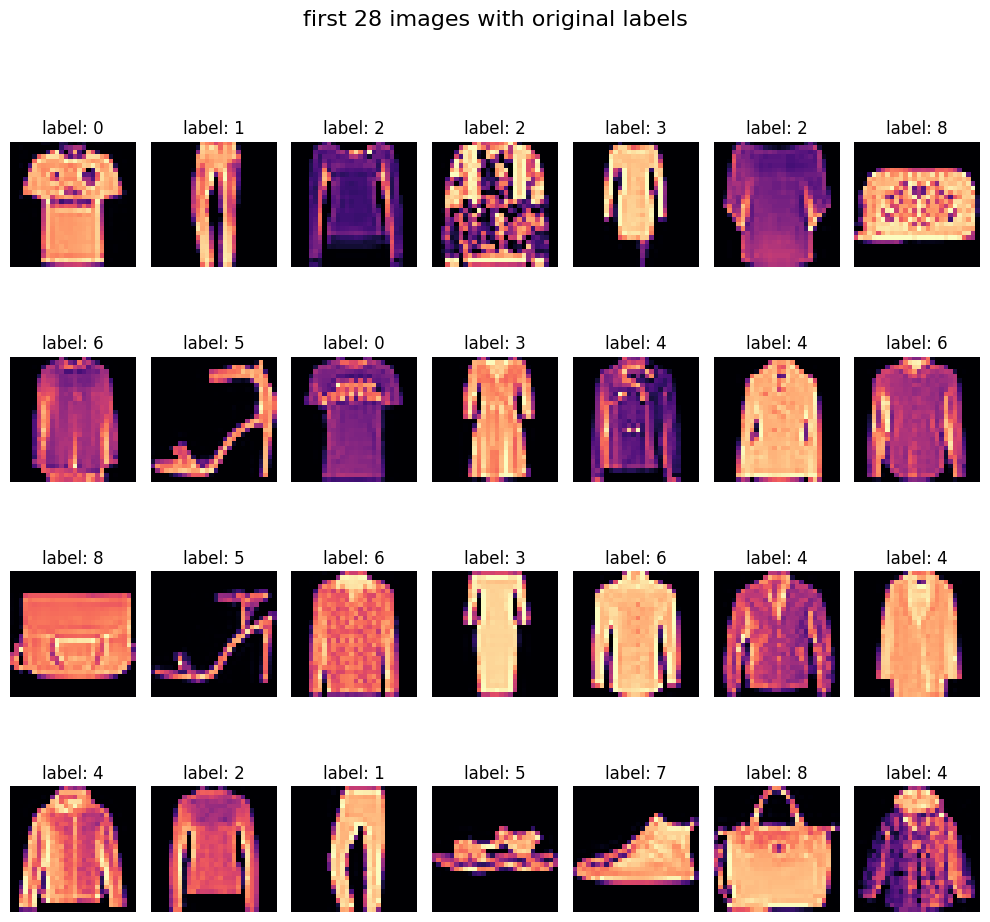

In [14]:

# Create subplots
fig, axes = plt.subplots(4, 7, figsize=(10, 10))  # Ensure fig is defined here
fig.suptitle('first 28 images with original labels', fontsize=16)

# Plot images
for i, ax in enumerate(axes.flat):
    img = Data1.iloc[i, 1:].values.reshape(28, 28)  # Reshape pixel data to 28x28
    ax.imshow(img, cmap='magma')  # Use cmap='gray' for grayscale images
    ax.axis('off')  # Remove axis ticks and labels
    ax.set_title(f'label: {Data1.iloc[i, 0]}')  # Set title to show label

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [15]:
X_Test=Data1
X_Test=X_Test.drop(columns='label',axis=1)
X_Test.insert(0,'label',y_test)

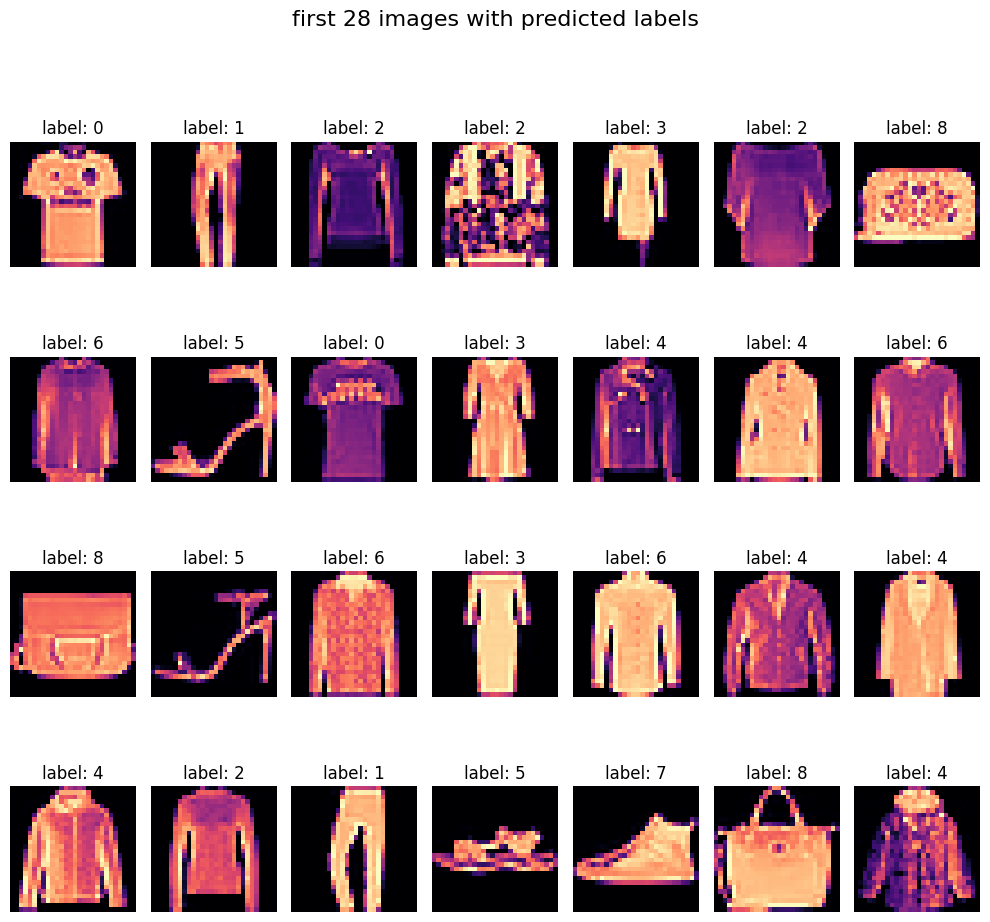

In [16]:
fig, axes = plt.subplots(4, 7, figsize=(10, 10))  # Ensure fig is defined here
fig.suptitle('first 28 images with predicted labels', fontsize=16)

# Plot images
for i, ax in enumerate(axes.flat):
    img = X_Test.iloc[i, 1:].values.reshape(28, 28)  # Reshape pixel data to 28x28
    ax.imshow(img, cmap='magma')  # Use cmap='gray' for grayscale images
    ax.axis('off')  # Remove axis ticks and labels
    ax.set_title(f'label: {X_Test.iloc[i, 0]}')  # Set title to show label

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

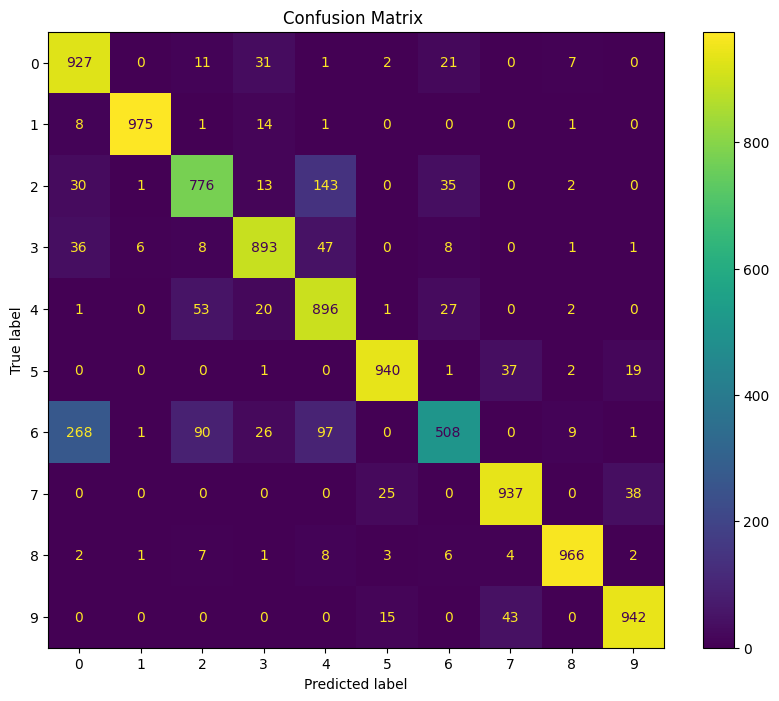

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example: True labels and Predicted labels for 10 classes

# Compute the confusion matrix
cm = confusion_matrix(y_test, prediction, labels=range(10))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(ax=ax, cmap='viridis')  # Use a colormap like 'viridis' for color

plt.title("Confusion Matrix ")
plt.show()